# Orbita3d Controller API example

## Installation

The easiest way to install the Orbita3d Controller API is via the `maturin develop` command from the `orbita3d_c_api` folder.

Please refer to [their documentation](https://www.maturin.rs/) for more information.


To check the install, simply run the following cell:

In [1]:
from orbita3d import Orbita3dController

You can create a new controller using the from_config method.

Configuration examples can be found in [the orbita3d_controller pacakge](https://github.com/pollen-robotics/orbita3d_control/tree/develop/orbita3d_controller/config).

In [2]:
# Replace the path with the path to your config file
config = "../../orbita3d_controller/config/ethercat_poulpe.yaml"

orbita3d_controller = Orbita3dController.from_config(config)

[2025-02-03T16:51:34Z ERROR poulpe_ethercat_grpc::client] No state found for slave 0


## Control your Orbita3d

### Enable/disable the torque

You can enable the torque using the `enable_torque` method. It also takes a `reset_target` argument that will reset the target position to the current position.

In [3]:
orbita3d_controller.enable_torque(reset_target=True)

You can now check that the torque was enabled by calling the `is_torque_on` method.

In [4]:
orbita3d_controller.is_torque_on()

True

And now, you can disable the torque using the `disable_torque` method.

In [5]:
orbita3d_controller.disable_torque()

Let's check that the torque is off.

In [6]:
orbita3d_controller.is_torque_on()

False

### Read and set orientation

To read the current orientation, you can use the `get_current_orientation` method. It returns a quaternion (qx, qy, qz, qw).

_Note that you can use the [Rotation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html) module from the scipy library to convert the quaternion to a rotation matrix or euler angles._

In [7]:
q = orbita3d_controller.get_current_orientation()
q

(0.04078224372829964,
 -0.10454252963501012,
 -0.04643914328483134,
 0.9925981432911152)

In [8]:
from scipy.spatial.transform import Rotation

roll, pitch, yaw = Rotation.from_quat(q).as_euler('xyz', degrees=True)
roll, pitch, yaw

(np.float64(5.31396256949761),
 np.float64(-11.75631493050894),
 np.float64(-5.904795824665887))

You can also set the target orientation using the `set_target_orientation` method. It takes a quaternion (qx, qy, qz, qw) as argument.

_Make sure to first enable the torque before setting the target orientation, otherwise your Orbita3d won't move._

In [9]:
orbita3d_controller.enable_torque(reset_target=True)

In [10]:
# Let's move the robot to a new orientation
# By setting its yaw to 30, 60, 90 degrees and back

import time

for yaw in [30, 60, 90, 60, 30, 0]:
    target = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_quat()
    print(target)
    #orbita3d_controller.set_target_orientation(target)
    fb=orbita3d_controller.set_target_orientation_fb(target)
    time.sleep(1)
    #current = orbita3d_controller.get_current_orientation()
    print(f"Target: {target} - Current: {fb}")

[ 0.07101948 -0.08688248  0.26176713  0.95858523]
Target: [ 0.07101948 -0.08688248  0.26176713  0.95858523] - Current: (0.0407433350158708, -0.10453702797727273, -0.0463705204426533, 0.9926035287401214)
[ 0.09108639 -0.06554084  0.50094774  0.85817191]
Target: [ 0.09108639 -0.06554084  0.50094774  0.85817191] - Current: (0.07106671552490945, -0.08692949820252852, 0.2619466757781423, 0.9585284155076149)
[ 0.10494591 -0.0397327   0.7059896   0.69927559]
Target: [ 0.10494591 -0.0397327   0.7059896   0.69927559] - Current: (0.09103715675098768, -0.06552714520874926, 0.5012467631764369, 0.858003561610692)
[ 0.09108639 -0.06554084  0.50094774  0.85817191]
Target: [ 0.09108639 -0.06554084  0.50094774  0.85817191] - Current: (0.1049059251091043, -0.039719315094160296, 0.7061416213325513, 0.6991288389898459)
[ 0.07101948 -0.08688248  0.26176713  0.95858523]
Target: [ 0.07101948 -0.08688248  0.26176713  0.95858523] - Current: (0.09105215051555528, -0.06552997225544806, 0.500882843780149, 0.85821

In [13]:
# Let's move the robot to a new orientation
# By setting its yaw to 30, 60, 90 degrees and back

import time

for yaw in [0]:
    target = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_quat()
    print(target)
    orbita3d_controller.set_target_orientation(target)
    #fb=orbita3d_controller.set_target_orientation_fb(target)
    time.sleep(1)
    #current = orbita3d_controller.get_current_orientation()
    print(f"Target: {target} - Current: {fb}")

[ 0.10483902 -0.23176772  0.02513326  0.96677858]
Target: [ 0.10483902 -0.23176772  0.02513326  0.96677858] - Current: (0.1610685133477313, -0.19680648388394395, 0.27425332490544185, 0.9274207543976469)


We can also play a more complex trajectory and record the current orientation at each step.

In [11]:
import numpy as np

dur = 10

pitch_sin_f = 0.25
pitch_sin_amp = 30

yaw_sin_f = 0.5
yaw_sin_amp = 60

data = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0

    roll = 0.0
    pitch = pitch_sin_amp * np.sin(2 * np.pi * pitch_sin_f * t)
    yaw = yaw_sin_amp * np.sin(2 * np.pi * yaw_sin_f * t)

    target = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_quat()
    orbita3d_controller.set_target_orientation(target)
    time.sleep(0.01)

    current = orbita3d_controller.get_current_orientation()
    data.append(current)

Using matplotlib, let's have a look at our trajectory.

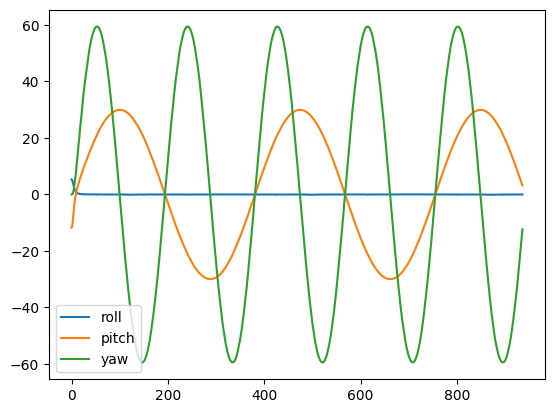

In [12]:
import matplotlib.pyplot as plt

roll, pitch, yaw = Rotation.from_quat(data).as_euler('xyz', degrees=True).T

plt.figure()
plt.plot(roll, label="roll")
plt.plot(pitch, label="pitch")
plt.plot(yaw, label="yaw")
plt.legend()


You can also access the velocity and torque using respectively the `get_current_velocity` and `get_current_torque` methods.

### Extra parameters

There are some extra parameters that you can access. **In opposition to the other values, those parameters impact directly the raw motor on not the actuator!**

You can access:
* the velocity limit using the `get_raw_motors_velocity_limit` and `set_raw_motors_velocity_limit` methods
* the torque limit using the `get_raw_motors_torque_limit` and `set_raw_motors_torque_limit` methods
* the pid gains using the `get_raw_motors_pid_gains` and `set_raw_motors_pid_gains` methods

In [18]:
orbita3d_controller.get_raw_motors_velocity_limit()

(1.0, 1.0, 1.0)

In [19]:
orbita3d_controller.get_raw_motors_torque_limit()

(1.0, 1.0, 1.0)

In [20]:
pids=orbita3d_controller.get_raw_motors_pid_gains()
pids[0][0]

0.0

In [3]:
orbita3d_controller.get_raw_motors_current()

AttributeError: cffi library '/home/reachy/reachy_ws/src/orbita3d_control/orbita3d_c_api/python/orbita3d/_orbita3d/lib_orbita3d.so' has no function, constant or global variable named 'orbita3d_get_raw_motors_torque'